In [1]:
!pip install kafka
!pip install kafka-python==2.0.2
!pip install requests
!pip install pyspark
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 4.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.5/246.5 kB 6.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 4.8 MB/s eta 0:00:00a 0:00:01


In [2]:
import socket
import json
import requests
import time

from kafka import KafkaProducer, KafkaConsumer

In [3]:
# Exercice 1
producer = KafkaProducer(
    bootstrap_servers=['kafka:9092'],
    value_serializer=lambda v: json.dumps(v).encode('utf-8')
)

msg = {"msg": "Hello Kafka"}
producer.send('weather_stream', msg)
producer.flush()

print("Message envoyé :", msg)

Message envoyé : {'msg': 'Hello Kafka'}


In [4]:
# Exercice 2
consumer = KafkaConsumer(
    'weather_stream',
    bootstrap_servers=['kafka:9092'],
    auto_offset_reset='earliest',
    value_deserializer=lambda m: json.loads(m.decode('utf-8')),
    consumer_timeout_ms=5000
)

for message in consumer:
    print(message.value)
    break

{'msg': 'Hello Kafka'}


In [5]:
# Exercice 3
def current_weather(lat, lon):
    url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&current_weather=true"
    response = requests.get(url)
    data = response.json()
    return data

lat = 48.8566
lon = 2.3522
weather_data = current_weather(lat, lon)

#print(weather_data)

producer.send('weather_stream', weather_data)
producer.flush()


In [6]:
# Exercice 4
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

spark = SparkSession.builder \
    .appName("WeatherProcessing") \
    .getOrCreate()

# creation de la session spark pour stream
df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "kafka:9092") \
    .option("subscribe", "weather_stream") \
    .load()

# lecture kafka depuis topic
json_schema = StructType([
    StructField("current_weather", StructType([
        StructField("temperature", DoubleType(), True),
        StructField("windspeed", DoubleType(), True),
        StructField("time", StringType(), True)
    ]), True)
])

parsed_df = df.select(
    from_json(col("value").cast("string"), json_schema).alias("data")
).select("data.current_weather.*")

processed_df = parsed_df.select(
    col("time").alias("event_time"),
    col("temperature"),
    col("windspeed"),
    when(col("windspeed") < 10, "level_0")
    .when((col("windspeed") >= 10) & (col("windspeed") <= 20), "level_1")
    .otherwise("level_2").alias("wind_alert_level"),
    when(col("temperature") < 25, "level_0")
    .when((col("temperature") >= 25) & (col("temperature") <= 35), "level_1")
    .otherwise("level_2").alias("heat_alert_level")
)

# ecriture dans le topic kafka
query = processed_df \
    .select(
        to_json(struct("*")).alias("value")
    ) \
    .writeStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "kafka:9092") \
    .option("topic", "weather_transformed") \
    .option("checkpointLocation", "./checkpoint") \
    .start()

In [7]:
# Exercice 5
from kafka import KafkaProducer
import json
import time

producer = KafkaProducer(
    bootstrap_servers=['kafka:9092'],
    value_serializer=lambda v: json.dumps(v).encode('utf-8')
)

for i in range(10):
    msg = {
        "event_time": time.strftime('%Y-%m-%d %H:%M:%S'),
        "temperature": 25.0 + i,
        "windspeed": 15.0 + i,
        "wind_alert_level": "level_1",
        "heat_alert_level": "level_0"
    }
    producer.send('weather_transformed', msg)
    time.sleep(1)

producer.flush()

In [8]:
# Exercice 5
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

spark = SparkSession.builder \
    .appName("WeatherAggregation") \
    .getOrCreate()

df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "kafka:9092") \
    .option("subscribe", "weather_transformed") \
    .load()

json_schema = StructType([
    StructField("event_time", StringType(), True),
    StructField("temperature", DoubleType(), True),
    StructField("windspeed", DoubleType(), True),
    StructField("wind_alert_level", StringType(), True),
    StructField("heat_alert_level", StringType(), True)
])

parsed_df = df.select(
    from_json(col("value").cast("string"), json_schema).alias("data")
).select("data.*")

with_watermark = parsed_df \
    .withColumn("event_time_ts", to_timestamp(col("event_time"))) \
    .withWatermark("event_time_ts", "10 minutes")

windowed_df = with_watermark \
    .groupBy(
        window(col("event_time_ts"), "5 minutes", "1 minute"),
        col("wind_alert_level"),
        col("heat_alert_level")
    ) \
    .agg(
        count(when(col("wind_alert_level").isin(["level_1", "level_2"]), 1)).alias("wind_alert_count"),
        count(when(col("heat_alert_level").isin(["level_1", "level_2"]), 1)).alias("heat_alert_count"),
        avg("temperature").alias("avg_temperature"),
        min("temperature").alias("min_temperature"),
        max("temperature").alias("max_temperature"),
        count("*").alias("total_alerts")
    )

output_df = windowed_df.select(
    col("window.start").alias("window_start"),
    col("window.end").alias("window_end"),
    col("wind_alert_level"),
    col("heat_alert_level"),
    col("wind_alert_count"),
    col("heat_alert_count"),
    col("avg_temperature"),
    col("min_temperature"),
    col("max_temperature"),
    col("total_alerts")
)

query = output_df \
    .writeStream \
    .format("console") \
    .outputMode("update") \
    .option("truncate", False) \
    .start()

print(query.isActive)
print(query.status)

True
{'message': 'Initializing sources', 'isDataAvailable': False, 'isTriggerActive': False}


In [9]:
# Exercice 6
from kafka import KafkaProducer
import json
import time

def get_coordinates(city, country):
    url = f"https://geocoding-api.open-meteo.com/v1/search?name={city}&count=1&language=en&format=json"
    response = requests.get(url)
    data = response.json()
    if data.get('results'):
        result = data['results'][0]
        return result['latitude'], result['longitude'], result['name'], result.get('country', country)
    return None, None, None, None

def weather_producer(city, country):
    lat, lon, city_name, country_name = get_coordinates(city, country)
    if not lat:
        print(f"Coordonnées non trouvées pour {city}, {country}")
        return

    url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&current_weather=true"
    response = requests.get(url)
    weather_data = response.json()

    current = weather_data.get("current_weather", {})
    temp = current.get("temperature", 0)
    wind = current.get("windspeed", 0)

    wind_level = "level_0" if wind < 10 else "level_1" if wind <= 20 else "level_2"
    heat_level = "level_0" if temp < 25 else "level_1" if temp <= 35 else "level_2"

    enriched_data = {
        "event_time": time.strftime('%Y-%m-%d %H:%M:%S'),
        "temperature": temp,
        "windspeed": wind,
        "wind_alert_level": wind_level,
        "heat_alert_level": heat_level,
        "city": city_name,
        "country": country_name,
        "latitude": lat,
        "longitude": lon,
        "timestamp": time.time()
    }

    producer = KafkaProducer(
        bootstrap_servers=['kafka:9092'],
        value_serializer=lambda v: json.dumps(v).encode('utf-8')
    )

    producer.send('weather_transformed', enriched_data)
    producer.flush()
    print(f"Message envoyé pour {city_name}, {country_name}")
    
# Liste de villes à interroger
cities_and_countries = [
    ("Paris", "France"),
    ("Berlin", "Germany"),
    ("Madrid", "Spain"),
    ("Rome", "Italy"),
    ("London", "UK"),
    ("Amsterdam", "Netherlands")
]

for city, country in cities_and_countries:
    for i in range(5):
        weather_producer(city, country)
        time.sleep(2)

Message envoyé pour Paris, France
Message envoyé pour Paris, France
Message envoyé pour Paris, France
Message envoyé pour Paris, France
Message envoyé pour Paris, France
Message envoyé pour Berlin, Germany
Message envoyé pour Berlin, Germany
Message envoyé pour Berlin, Germany
Message envoyé pour Berlin, Germany
Message envoyé pour Berlin, Germany
Message envoyé pour Madrid, Spain
Message envoyé pour Madrid, Spain
Message envoyé pour Madrid, Spain
Message envoyé pour Madrid, Spain
Message envoyé pour Madrid, Spain
Message envoyé pour Rome, Italy
Message envoyé pour Rome, Italy
Message envoyé pour Rome, Italy
Message envoyé pour Rome, Italy
Message envoyé pour Rome, Italy
Message envoyé pour London, United Kingdom
Message envoyé pour London, United Kingdom
Message envoyé pour London, United Kingdom
Message envoyé pour London, United Kingdom
Message envoyé pour London, United Kingdom
Message envoyé pour Amsterdam, The Netherlands
Message envoyé pour Amsterdam, The Netherlands
Message env

In [10]:
# Exercice 7
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

spark = SparkSession.builder \
    .appName("KafkaToHDFS") \
    .config("spark.sql.streaming.checkpointLocation", "/tmp/checkpoint_hdfs") \
    .getOrCreate()

df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "kafka:9092") \
    .option("subscribe", "weather_transformed") \
    .load()

json_schema = StructType([
    StructField("event_time", StringType(), True),
    StructField("temperature", DoubleType(), True),
    StructField("windspeed", DoubleType(), True),
    StructField("wind_alert_level", StringType(), True),
    StructField("heat_alert_level", StringType(), True),
    StructField("city", StringType(), True),
    StructField("country", StringType(), True)
])

parsed_df = df.select(
    from_json(col("value").cast("string"), json_schema).alias("data")
).select("data.*")

def save_to_hdfs(batch_df, batch_id):
    if not batch_df.rdd.isEmpty():
        batch_df.coalesce(1).write \
            .mode("append") \
            .partitionBy("country", "city") \
            .json("hdfs://namenode:9000/hdfs-data/alerts")

query = parsed_df \
    .writeStream \
    .foreachBatch(save_to_hdfs) \
    .option("checkpointLocation", "/tmp/checkpoint_hdfs_write") \
    .start()

In [11]:
# Vérifier le contenu de HDFS avec Spark
try:
    hdfs_df = spark.read.json("hdfs://namenode:9000/hdfs-data/alerts")
    hdfs_df.show(10, truncate=False)
    #hdfs_df.printSchema()
except Exception as e:
    print("Erreur lors de la lecture HDFS:", str(e))

+-------------------+----------------+-----------+----------------+---------+-------+------+
|event_time         |heat_alert_level|temperature|wind_alert_level|windspeed|country|city  |
+-------------------+----------------+-----------+----------------+---------+-------+------+
|2025-11-12 11:28:39|level_0         |10.0       |level_1         |11.5     |Germany|Berlin|
|2025-11-12 11:28:41|level_0         |10.0       |level_1         |11.5     |Germany|Berlin|
|2025-11-12 11:28:43|level_0         |10.0       |level_1         |11.5     |Germany|Berlin|
|2025-11-12 11:28:46|level_0         |10.0       |level_1         |11.5     |Germany|Berlin|
|2025-11-12 11:28:48|level_0         |10.0       |level_1         |11.5     |Germany|Berlin|
|2025-11-12 11:30:23|level_0         |10.4       |level_1         |11.0     |Germany|Berlin|
|2025-11-12 11:30:25|level_0         |10.4       |level_1         |11.0     |Germany|Berlin|
|2025-11-12 11:30:28|level_0         |10.4       |level_1         |11.

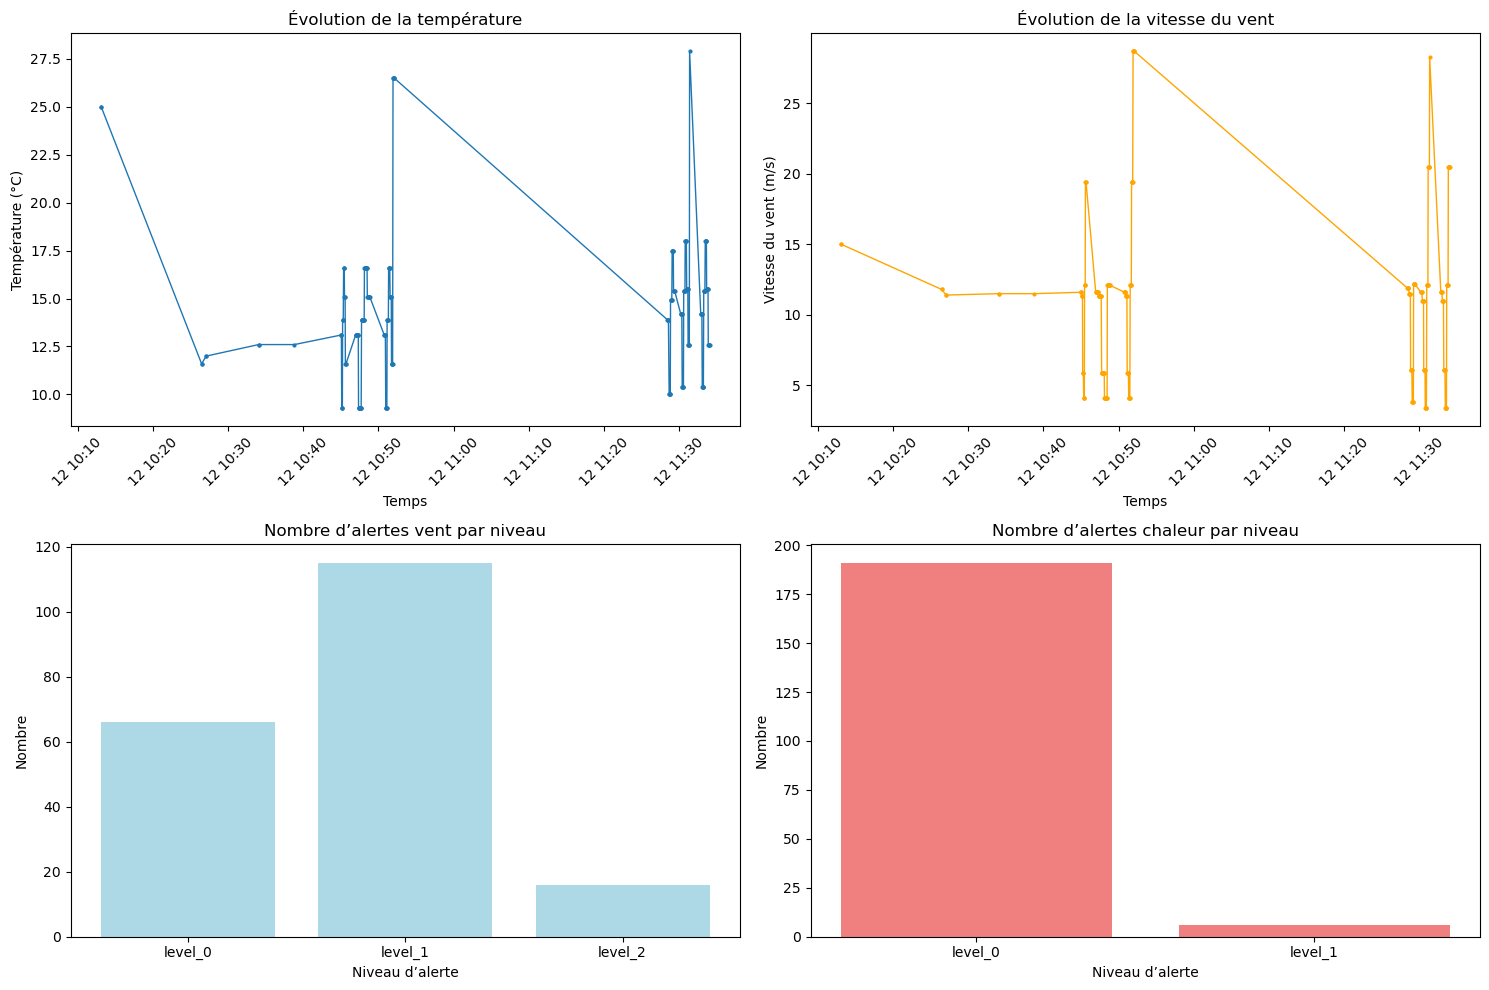

Niveau d'alerte chaleur le plus fréquent par pays:
country
France             level_0
Germany            level_0
Italy              level_0
Morocco            level_1
Spain              level_0
The Netherlands    level_0
United Kingdom     level_0


In [12]:
import matplotlib.pyplot as plt
import pandas as pd

hdfs_df = spark.read.json("hdfs://namenode:9000/hdfs-data/alerts")

df_pandas = hdfs_df.toPandas()

# Nettoyage
df_pandas = df_pandas.dropna(subset=['city', 'country'])

# Tri par timestamp
df_pandas['event_time'] = pd.to_datetime(df_pandas['event_time'])
df_pandas = df_pandas.sort_values('event_time').reset_index(drop=True)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Évolution de la température
axes[0,0].plot(df_pandas['event_time'], df_pandas['temperature'], marker='o', markersize=2, linewidth=1)
axes[0,0].set_title('Évolution de la température')
axes[0,0].set_xlabel('Temps')
axes[0,0].set_ylabel('Température (°C)')
axes[0,0].tick_params(axis='x', rotation=45)

# Évolution de la vitesse du vent
axes[0,1].plot(df_pandas['event_time'], df_pandas['windspeed'], marker='o', markersize=2, linewidth=1, color='orange')
axes[0,1].set_title('Évolution de la vitesse du vent')
axes[0,1].set_xlabel('Temps')
axes[0,1].set_ylabel('Vitesse du vent (m/s)')
axes[0,1].tick_params(axis='x', rotation=45)

# Alertes vent par niveau
wind_counts = df_pandas['wind_alert_level'].value_counts().sort_index()
axes[1,0].bar(wind_counts.index, wind_counts.values, color='lightblue')
axes[1,0].set_title('Nombre d’alertes vent par niveau')
axes[1,0].set_xlabel('Niveau d’alerte')
axes[1,0].set_ylabel('Nombre')

# Alertes chaleur par niveau
heat_counts = df_pandas['heat_alert_level'].value_counts().sort_index()
axes[1,1].bar(heat_counts.index, heat_counts.values, color='lightcoral')
axes[1,1].set_title('Nombre d’alertes chaleur par niveau')
axes[1,1].set_xlabel('Niveau d’alerte')
axes[1,1].set_ylabel('Nombre')

plt.tight_layout()
plt.show()

# Code météo le plus fréquent par pays
country_alerts = df_pandas.groupby('country')['heat_alert_level'].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else 'N/A'
)

print("Niveau d'alerte chaleur le plus fréquent par pays:")
print(country_alerts.to_string())

In [13]:
# Lecture des données depuis HDFS
hdfs_df = spark.read.json("hdfs://namenode:9000/hdfs-data/alerts")
df_pandas = hdfs_df.toPandas()

# Affichage des premières lignes pour inspection
print("Premières lignes des données :")
print(df_pandas.head(10))

# Informations générales sur le dataset
print("\nInformations sur le dataset :")
print(df_pandas.info())

# Statistiques descriptives
print("\nStatistiques descriptives :")
print(df_pandas.describe())

# Valeurs uniques pour les alertes
print("\nValeurs uniques - Niveaux d'alerte vent :")
print(df_pandas['wind_alert_level'].value_counts())
print("\nValeurs uniques - Niveaux d'alerte chaleur :")
print(df_pandas['heat_alert_level'].value_counts())

# Vérification des timestamps
print("\nPlage temporelle des données :")
df_pandas['event_time'] = pd.to_datetime(df_pandas['event_time'])
print(f"Min: {df_pandas['event_time'].min()}")
print(f"Max: {df_pandas['event_time'].max()}")
print(f"Nombre de points: {len(df_pandas)}")

Premières lignes des données :
            event_time heat_alert_level  temperature wind_alert_level  \
0  2025-11-12 11:28:39          level_0         10.0          level_1   
1  2025-11-12 11:28:41          level_0         10.0          level_1   
2  2025-11-12 11:28:43          level_0         10.0          level_1   
3  2025-11-12 11:28:46          level_0         10.0          level_1   
4  2025-11-12 11:28:48          level_0         10.0          level_1   
5  2025-11-12 11:30:23          level_0         10.4          level_1   
6  2025-11-12 11:30:25          level_0         10.4          level_1   
7  2025-11-12 11:30:28          level_0         10.4          level_1   
8  2025-11-12 11:30:30          level_0         10.4          level_1   
9  2025-11-12 11:30:33          level_0         10.4          level_1   

   windspeed  country    city  
0       11.5  Germany  Berlin  
1       11.5  Germany  Berlin  
2       11.5  Germany  Berlin  
3       11.5  Germany  Berlin  
4    

In [14]:
# Exercice 9
import requests
import json
from kafka import KafkaProducer
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *

def get_coordinates(city, country):
    url = f"https://geocoding-api.open-meteo.com/v1/search?name={city}&count=1&language=en&format=json"
    response = requests.get(url)
    data = response.json()
    if data.get('results'):
        result = data['results'][0]
        return result['latitude'], result['longitude'], result['name'], result.get('country', country)
    return None, None, None, None

def send_historical_data_to_kafka(city, country):
    lat, lon, city_name, country_name = get_coordinates(city, country)
    if not lat:
        print(f"Coordonnées non trouvées pour {city}, {country}")
        return 0

    url = (
        "https://archive-api.open-meteo.com/v1/archive"
        f"?latitude={lat}&longitude={lon}"
        "&start_date=2020-01-01&end_date=2024-12-31"
        "&hourly=temperature_2m,windspeed_10m"
        "&timezone=UTC"
    )
    
    response = requests.get(url)
    data = response.json()
    
    if 'error' in data:
        print("Erreur API :", data)
        return 0
    
    hourly = data.get('hourly', {})
    times = hourly.get('time', [])
    temps = hourly.get('temperature_2m', [])
    winds = hourly.get('windspeed_10m', [])
    
    if not times:
        print("Aucune donnée horaire reçue")
        return 0
    
    producer = KafkaProducer(
        bootstrap_servers=['kafka:9092'],
        value_serializer=lambda v: json.dumps(v).encode('utf-8')
    )
    
    count = 0
    for i in range(len(times)):
        record = {
            "event_time": times[i],
            "temperature": temps[i] if i < len(temps) else None,
            "windspeed": winds[i] if i < len(winds) else None,
            "city": city_name,
            "country": country_name,
            "latitude": lat,
            "longitude": lon
        }
        producer.send('weather_history_raw', record)
        count += 1
    
    producer.flush()
    print(f"{count} enregistrements envoyés vers Kafka")
    return count

In [15]:

spark = SparkSession.builder \
    .appName("HistoricalWeatherToHDFS") \
    .config("spark.sql.streaming.checkpointLocation", "/tmp/checkpoint_historical") \
    .getOrCreate()

df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "kafka:9092") \
    .option("subscribe", "weather_history_raw") \
    .load()

json_schema = StructType([
    StructField("event_time", StringType(), True),
    StructField("temperature", DoubleType(), True),
    StructField("windspeed", DoubleType(), True),
    StructField("city", StringType(), True),
    StructField("country", StringType(), True),
    StructField("latitude", DoubleType(), True),
    StructField("longitude", DoubleType(), True)
])

parsed_df = df.select(
    from_json(col("value").cast("string"), json_schema).alias("data")
).select("data.*")

def save_historical_to_hdfs(batch_df, batch_id):
    if not batch_df.rdd.isEmpty():
        batch_df.coalesce(1).write \
            .mode("append") \
            .partitionBy("country", "city") \
            .json("hdfs://namenode:9000/hdfs-data/weather_history_raw")

query = parsed_df \
    .writeStream \
    .foreachBatch(save_historical_to_hdfs) \
    .option("checkpointLocation", "/tmp/checkpoint_historical") \
    .start()

send_historical_data_to_kafka("Paris", "France")

print("\nAttente de 10 secondes pour la synchronisation HDFS...")
import time
time.sleep(10)

try:
    history_df = spark.read.json("hdfs://namenode:9000/hdfs-data/weather_history_raw")
    print(f"\nDonnées trouvées dans HDFS : {history_df.count()} enregistrements")
    history_df.show(15, truncate=False)
except Exception as e:
    print(f"\nErreur lecture HDFS : {str(e)}")

43848 enregistrements envoyés vers Kafka

Attente de 10 secondes pour la synchronisation HDFS...

Données trouvées dans HDFS : 306936 enregistrements
+----------------+--------+---------+-----------+---------+-------+-----+
|event_time      |latitude|longitude|temperature|windspeed|country|city |
+----------------+--------+---------+-----------+---------+-------+-----+
|2022-01-30T13:00|48.85341|2.3488   |9.3        |4.2      |France |Paris|
|2022-01-30T14:00|48.85341|2.3488   |9.4        |5.4      |France |Paris|
|2022-01-30T15:00|48.85341|2.3488   |9.3        |6.5      |France |Paris|
|2022-01-30T16:00|48.85341|2.3488   |8.3        |3.9      |France |Paris|
|2022-01-30T17:00|48.85341|2.3488   |8.1        |4.0      |France |Paris|
|2022-01-30T18:00|48.85341|2.3488   |6.3        |5.2      |France |Paris|
|2022-01-30T19:00|48.85341|2.3488   |7.0        |3.6      |France |Paris|
|2022-01-30T20:00|48.85341|2.3488   |6.3        |3.5      |France |Paris|
|2022-01-30T21:00|48.85341|2.3488   

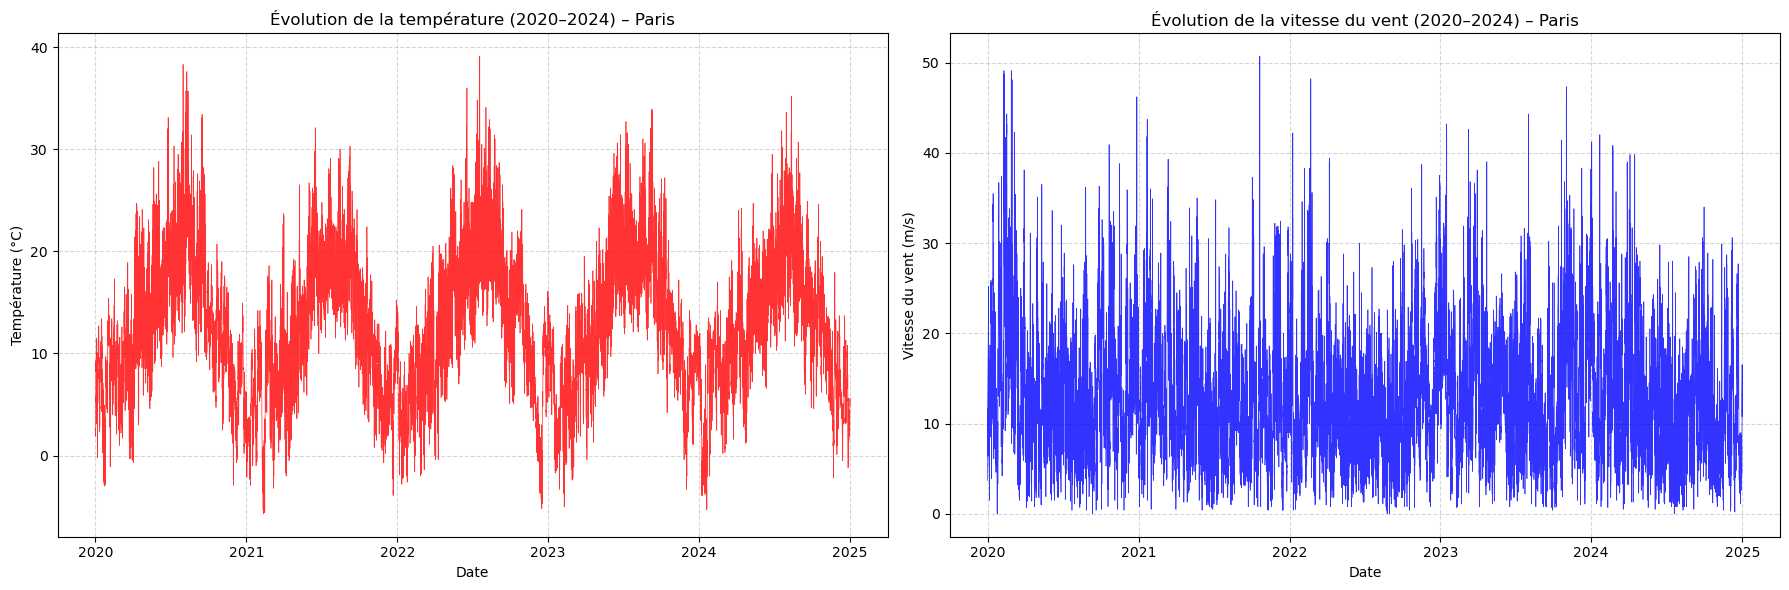

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
# Recuperation des donnée depuis le HDFS pour un visuel

history_df = spark.read.json("hdfs://namenode:9000/hdfs-data/weather_history_raw")

df = history_df.toPandas()

df['event_time'] = pd.to_datetime(df['event_time'])

df = df.sort_values('event_time').reset_index(drop=True)

plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(df['event_time'], df['temperature'], color='red', linewidth=0.5, alpha=0.8)
plt.title('Évolution de la température (2020–2024) – Paris')
plt.xlabel('Date')
plt.ylabel('Température (°C)')
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(1, 2, 2)
plt.plot(df['event_time'], df['windspeed'], color='blue', linewidth=0.5, alpha=0.8)
plt.title('Évolution de la vitesse du vent (2020–2024) – Paris')
plt.xlabel('Date')
plt.ylabel('Vitesse du vent (m/s)')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [17]:
# Exercice 10
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

spark = SparkSession.builder \
    .appName("WeatherRecords") \
    .getOrCreate()

df = spark.read.json("hdfs://namenode:9000/hdfs-data/weather_history_raw")

df = df.withColumn("event_time", to_timestamp(col("event_time")))

records_df = df.groupBy("country", "city") \
    .agg(
        max(struct(col("temperature"), col("event_time"))).alias("hottest_day"),
        min(struct(col("temperature"), col("event_time"))).alias("coldest_day"),
        max(struct(col("windspeed"), col("event_time"))).alias("strongest_wind")
    )

records_df = records_df.select(
    col("country"),
    col("city"),
    col("hottest_day.event_time").alias("hottest_day_date"),
    col("hottest_day.temperature").alias("hottest_day_temp"),
    col("coldest_day.event_time").alias("coldest_day_date"),
    col("coldest_day.temperature").alias("coldest_day_temp"),
    col("strongest_wind.event_time").alias("strongest_wind_date"),
    col("strongest_wind.windspeed").alias("strongest_wind_speed")
)

records_json = records_df.select(
    to_json(
        struct(
            "country",
            "city",
            "hottest_day_date",
            "hottest_day_temp",
            "coldest_day_date",
            "coldest_day_temp",
            "strongest_wind_date",
            "strongest_wind_speed"
        )
    ).alias("value")
)

records_json.write \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "kafka:9092") \
    .option("topic", "weather_records") \
    .save()

In [18]:
# Exercice 11 
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

spark = SparkSession.builder \
    .appName("SeasonalProfile") \
    .getOrCreate()

df = spark.read.json("hdfs://namenode:9000/hdfs-data/weather_history_raw")

df = df.withColumn("event_time", to_timestamp(col("event_time"))) \
       .withColumn("month", month(col("event_time")))

df = df.withColumn("wind_alert_level",
    when(col("windspeed") < 10, "level_0")
    .when((col("windspeed") >= 10) & (col("windspeed") <= 20), "level_1")
    .otherwise("level_2")
)

df = df.withColumn("is_wind_alert", 
    (col("wind_alert_level").isin(["level_1", "level_2"])).cast("integer")
)

seasonal_df = df.groupBy("country", "city", "month") \
    .agg(
        avg("temperature").alias("avg_temperature"),
        avg("windspeed").alias("avg_windspeed"),
        avg("is_wind_alert").alias("wind_alert_probability")
    )

seasonal_df.coalesce(1) \
    .write \
    .mode("overwrite") \
    .partitionBy("country", "city") \
    .json("hdfs://namenode:9000/hdfs-data/seasonal_profile")

In [19]:
# Exercice 12
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

spark = SparkSession.builder \
    .appName("EnrichedSeasonalProfile") \
    .getOrCreate()

df = spark.read.json("hdfs://namenode:9000/hdfs-data/weather_history_raw")

df = df.withColumn("event_time", to_timestamp(col("event_time"))) \
       .withColumn("year", year(col("event_time"))) \
       .withColumn("month", month(col("event_time")))

df = df.filter(col("temperature").between(-50, 60)) \
       .filter(col("windspeed").between(0, 60))

enriched_df = df.groupBy("country", "city", "year", "month") \
    .agg(
        avg("temperature").alias("avg_temperature"),
        stddev("temperature").alias("std_temperature"),
        min("temperature").alias("min_temperature"),
        max("temperature").alias("max_temperature"),
        expr("percentile_approx(temperature, 0.5)").alias("median_temperature"),
        expr("percentile_approx(temperature, 0.25)").alias("q25_temperature"),
        expr("percentile_approx(temperature, 0.75)").alias("q75_temperature"),
        avg("windspeed").alias("avg_windspeed"),
        stddev("windspeed").alias("std_windspeed"),
        min("windspeed").alias("min_windspeed"),
        max("windspeed").alias("max_windspeed"),
        expr("percentile_approx(windspeed, 0.5)").alias("median_windspeed"),
        expr("percentile_approx(windspeed, 0.25)").alias("q25_windspeed"),
        expr("percentile_approx(windspeed, 0.75)").alias("q75_windspeed"),
        count("*").alias("days_in_month")
    )

complete_months = enriched_df.groupBy("country", "city") \
    .agg(countDistinct("month").alias("months_available")) \
    .filter(col("months_available") == 12)

valid_df = enriched_df.join(complete_months.select("country", "city"), ["country", "city"])

valid_df.coalesce(1) \
    .write \
    .mode("overwrite") \
    .partitionBy("country", "city", "year") \
    .json("hdfs://namenode:9000/hdfs-data/seasonal_profile_enriched")

In [22]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

spark = SparkSession.builder \
    .appName("AnomalyDetection") \
    .getOrCreate()

realtime_df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "kafka:9092") \
    .option("subscribe", "weather_transformed") \
    .load()

json_schema = StructType([
    StructField("event_time", StringType(), True),
    StructField("temperature", DoubleType(), True),
    StructField("windspeed", DoubleType(), True),
    StructField("wind_alert_level", StringType(), True),
    StructField("heat_alert_level", StringType(), True),
    StructField("city", StringType(), True),
    StructField("country", StringType(), True)
])

parsed_realtime = realtime_df.select(
    from_json(col("value").cast("string"), json_schema).alias("data")
).select("data.*") \
   .withColumn("event_time", to_timestamp(col("event_time"))) \
   .withColumn("month", month(col("event_time")))

historical_df = spark.read.json("hdfs://namenode:9000/hdfs-data/seasonal_profile_enriched")

joined_df = parsed_realtime.join(
    historical_df,
    ["country", "city", "month"],
    "inner"
)

anomaly_df = joined_df.withColumn(
    "temp_anomaly",
    abs(col("temperature") - col("avg_temperature")) > 2
).withColumn(
    "wind_anomaly",
    col("windspeed") > (col("avg_windspeed") + 1 * col("std_windspeed"))
).withColumn(
    "anomaly_type",
    when(col("temp_anomaly"), "temperature")
    .when(col("wind_anomaly"), "wind")
    .otherwise("none")
).withColumn(
    "is_anomaly",
    col("anomaly_type") != "none"
).filter(col("is_anomaly"))

output_df = anomaly_df.select(
    col("city"),
    col("country"),
    col("event_time"),
    when(col("temp_anomaly"), "temperature")
    .otherwise("wind").alias("variable"),
    coalesce(col("temperature"), col("windspeed")).alias("observed_value"),
    when(col("temp_anomaly"), col("avg_temperature"))
    .otherwise(col("avg_windspeed")).alias("expected_value"),
    col("anomaly_type")
)

def save_anomalies(batch_df, batch_id):
    if not batch_df.rdd.isEmpty():
        batch_df.coalesce(1).write \
            .mode("append") \
            .partitionBy("country", "city") \
            .json("hdfs://namenode:9000/hdfs-data/anomalies")

query = output_df \
    .select(to_json(struct("*")).alias("value")) \
    .writeStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "kafka:9092") \
    .option("topic", "weather_anomalies") \
    .option("checkpointLocation", "/tmp/checkpoint_anomalies") \
    .start()

write_hdfs_query = output_df \
    .writeStream \
    .foreachBatch(save_anomalies) \
    .option("checkpointLocation", "/tmp/checkpoint_anomalies_hdfs") \
    .start()